# Workshop 9 - Introduction to Convolutional Neural Networks

Code for workshop 9.  This will use Keras (within tensorflow v2) to build a small CNN

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

In [2]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


## Load data
We will use fashion MNIST, which is a set of small images (28x28) that contain 10 different fashion items - see below for class names and an example image.

In [3]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 6s 0us/step


In [4]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


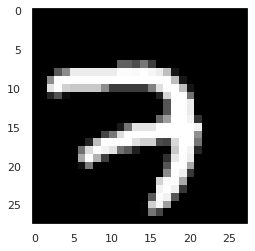

In [5]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

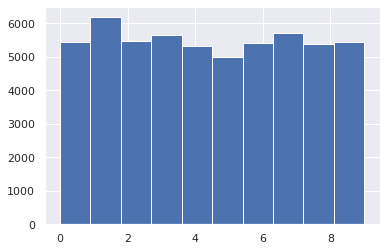

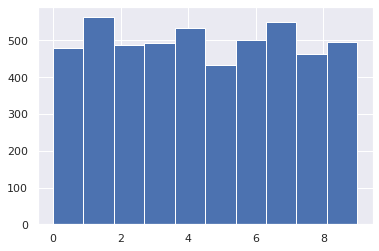

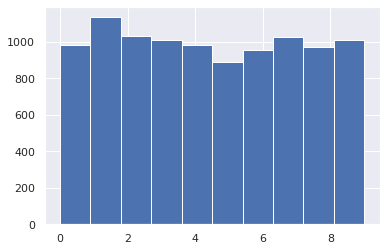

In [6]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [7]:
# Some key parameters
n_train = 3000
n_valid = 1000
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
actfn = "relu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [8]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

In [9]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter 
#  which requires the convolution to be "valid" and not "same"

In [10]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [11]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [12]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True) 

In [13]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size):
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb],
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

In [14]:
valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 246us/sample - loss: 2.2712 - accuracy: 0.2497 - val_loss: 2.2366 - val_accuracy: 0.3040
Epoch 2/20
3000/3000 [==============================] - 0s 143us/sample - loss: 2.1716 - accuracy: 0.3650 - val_loss: 2.0625 - val_accuracy: 0.5650
Epoch 3/20
3000/3000 [==============================] - 0s 150us/sample - loss: 1.6836 - accuracy: 0.6347 - val_loss: 1.1267 - val_accuracy: 0.7080
Epoch 4/20
3000/3000 [==============================] - 0s 149us/sample - loss: 0.7730 - accuracy: 0.7773 - val_loss: 0.6658 - val_accuracy: 0.7970
Epoch 5/20
3000/3000 [==============================] - 0s 144us/sample - loss: 0.5197 - accuracy: 0.8377 - val_loss: 0.5434 - val_accuracy: 0.8290
Epoch 6/20
3000/3000 [==============================] - 0s 144us/sample - loss: 0.4228 - accuracy: 0.8730 - val_loss: 0.5107 - val_accuracy: 0.8400
Epoch 7/20
3000/3000 [==============================] - 0s 145us

In [22]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

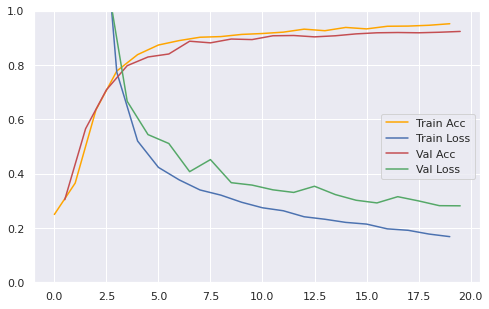

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7

In [25]:
plot_history(history)
model.summary()

[7 2 1]
['7' '2' '1']
['7' '2' '1']


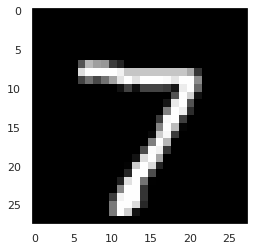

In [16]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test[:3])  # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [17]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.24441256075203419, 0.9276]


In [18]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.01 0.  ]]


# Exploring parameters

For example, why make these particular choices for architecture and parameters.

Let us systematically vary one parameter at a time.

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 221us/sample - loss: 2.3175 - accuracy: 0.0980 - val_loss: 2.3131 - val_accuracy: 0.0930
Epoch 2/20
3000/3000 [==============================] - 0s 152us/sample - loss: 2.3084 - accuracy: 0.1137 - val_loss: 2.3045 - val_accuracy: 0.1170
Epoch 3/20
3000/3000 [==============================] - 0s 146us/sample - loss: 2.3093 - accuracy: 0.1023 - val_loss: 2.3054 - val_accuracy: 0.1160
Epoch 4/20
3000/3000 [==============================] - 0s 146us/sample - loss: 2.3095 - accuracy: 0.1010 - val_loss: 2.3088 - val_accuracy: 0.0930
Epoch 5/20
3000/3000 [==============================] - 0s 145us/sample - loss: 2.3073 - accuracy: 0.1030 - val_loss: 2.3118 - val_accuracy: 0.0940


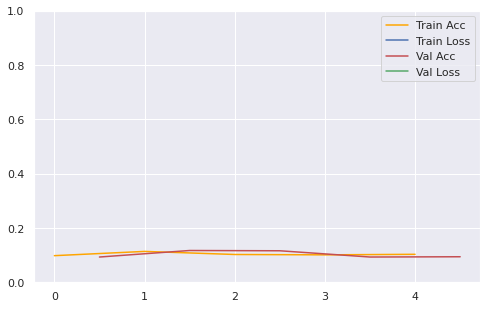

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 245us/sample - loss: 1.2657 - accuracy: 0.5967 - val_loss: 0.4796 - val_accuracy: 0.8510
Epoch 2/20
3000/3000 [==============================] - 0s 152us/sample - loss: 0.3505 - accuracy: 0.8967 - val_loss: 0.3674 - val_accuracy: 0.8850
Epoch 3/20
3000/3000 [==============================] - 0s 147us/sample - loss: 0.2232 - accuracy: 0.9330 - val_loss: 0.2589 - val_accuracy: 0.9250
Epoch 4/20
3000/3000 [==============================] - 0s 145us/sample - loss: 0.1602 - accuracy: 0.9487 - val_loss: 0.2403 - val_accuracy: 0.9280
Epoch 5/20
3000/3000 [==============================] - 0s 151us/sample - loss: 0.1255 - accuracy: 0.9590 - val_loss: 0.2276 - val_accuracy: 0.9330
Epoch 6/20
3000/3000 [==============================] - 0s 149us/sample - loss: 0.0989 - accuracy: 0.9670 - val_loss: 0.2321 - val_accuracy: 0.9370
Epoch 7/20
3000/3000 [==============================] - 0s 146us

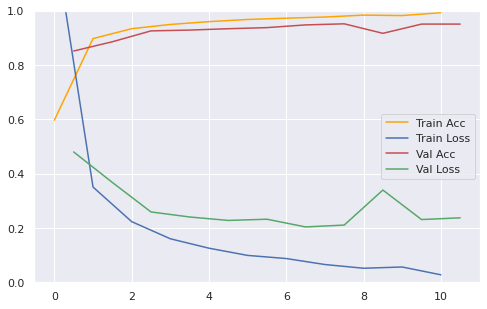

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 218us/sample - loss: 2.2716 - accuracy: 0.1727 - val_loss: 2.2356 - val_accuracy: 0.2730
Epoch 2/20
3000/3000 [==============================] - 0s 148us/sample - loss: 2.1593 - accuracy: 0.4000 - val_loss: 2.0408 - val_accuracy: 0.5830
Epoch 3/20
3000/3000 [==============================] - 0s 148us/sample - loss: 1.6255 - accuracy: 0.6487 - val_loss: 1.0871 - val_accuracy: 0.6890
Epoch 4/20
3000/3000 [==============================] - 0s 145us/sample - loss: 0.7683 - accuracy: 0.7693 - val_loss: 0.5957 - val_accuracy: 0.8230
Epoch 5/20
3000/3000 [==============================] - 0s 148us/sample - loss: 0.5240 - accuracy: 0.8407 - val_loss: 0.5283 - val_accuracy: 0.8480
Epoch 6/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.4432 - accuracy: 0.8623 - val_loss: 0.4706 - val_accuracy: 0.8660
Epoch 7/20
3000/3000 [==============================] - 0s 155us

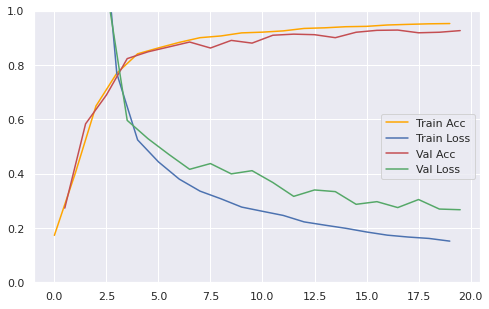

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 230us/sample - loss: 2.2978 - accuracy: 0.0627 - val_loss: 2.2908 - val_accuracy: 0.0800
Epoch 2/20
3000/3000 [==============================] - 0s 150us/sample - loss: 2.2871 - accuracy: 0.1010 - val_loss: 2.2801 - val_accuracy: 0.1250
Epoch 3/20
3000/3000 [==============================] - 0s 147us/sample - loss: 2.2761 - accuracy: 0.1380 - val_loss: 2.2688 - val_accuracy: 0.1600
Epoch 4/20
3000/3000 [==============================] - 0s 144us/sample - loss: 2.2645 - accuracy: 0.1567 - val_loss: 2.2566 - val_accuracy: 0.1760
Epoch 5/20
3000/3000 [==============================] - 0s 148us/sample - loss: 2.2518 - accuracy: 0.1793 - val_loss: 2.2430 - val_accuracy: 0.1950
Epoch 6/20
3000/3000 [==============================] - 0s 151us/sample - loss: 2.2373 - accuracy: 0.2067 - val_loss: 2.2275 - val_accuracy: 0.2150
Epoch 7/20
3000/3000 [==============================] - 0s 151us

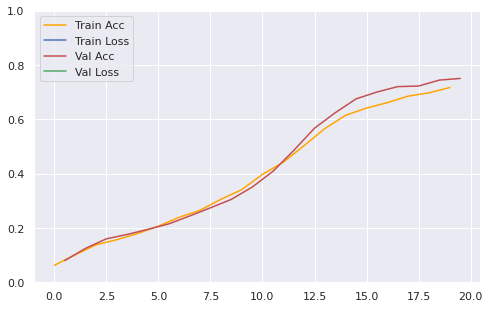

[[1.0, 0.117, 0.1028], [0.1, 0.951, 0.9559], [0.01, 0.928, 0.9287], [0.001, 0.75, 0.7193]]


In [26]:
# Learning rate
res=[]
for lr in [100, 10, 1, 0.1]:
    valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[lr*learningrate,valacc,testacc]]
print(res)

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 186us/sample - loss: 2.2429 - accuracy: 0.2330 - val_loss: 2.1173 - val_accuracy: 0.4090
Epoch 2/20
3000/3000 [==============================] - 0s 128us/sample - loss: 1.5244 - accuracy: 0.6547 - val_loss: 0.8339 - val_accuracy: 0.7770
Epoch 3/20
3000/3000 [==============================] - 0s 125us/sample - loss: 0.6153 - accuracy: 0.8187 - val_loss: 0.5522 - val_accuracy: 0.8280
Epoch 4/20
3000/3000 [==============================] - 0s 129us/sample - loss: 0.4825 - accuracy: 0.8490 - val_loss: 0.4595 - val_accuracy: 0.8660
Epoch 5/20
3000/3000 [==============================] - 0s 120us/sample - loss: 0.4133 - accuracy: 0.8760 - val_loss: 0.6107 - val_accuracy: 0.8180
Epoch 6/20
3000/3000 [==============================] - 0s 123us/sample - loss: 0.3747 - accuracy: 0.8870 - val_loss: 0.4354 - val_accuracy: 0.8700
Epoch 7/20
3000/3000 [==============================] - 0s 127us

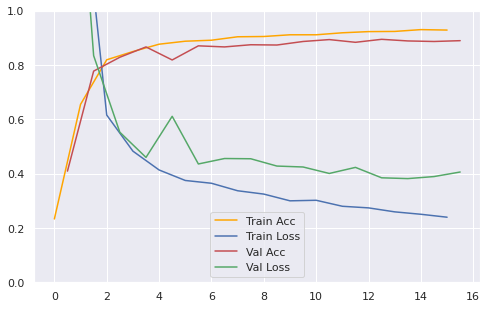

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 188us/sample - loss: 1.7925 - accuracy: 0.5133 - val_loss: 0.9792 - val_accuracy: 0.7810
Epoch 2/20
3000/3000 [==============================] - 0s 121us/sample - loss: 0.6682 - accuracy: 0.8123 - val_loss: 0.6514 - val_accuracy: 0.7690
Epoch 3/20
3000/3000 [==============================] - 0s 121us/sample - loss: 0.4798 - accuracy: 0.8563 - val_loss: 0.4676 - val_accuracy: 0.8660
Epoch 4/20
3000/3000 [==============================] - 0s 122us/sample - loss: 0.4055 - accuracy: 0.8777 - val_loss: 0.4429 - val_accuracy: 0.8740
Epoch 5/20
3000/3000 [==============================] - 0s 122us/sample - loss: 0.3754 - accuracy: 0.8867 - val_loss: 0.4525 - val_accuracy: 0.8640
Epoch 6/20
3000/3000 [==============================] - 0s 122us/sample - loss: 0.3462 - accuracy: 0.8943 - val_loss: 0.4914 - val_accuracy: 0.8510
Epoch 7/20
3000/3000 [==============================] - 0s 121us

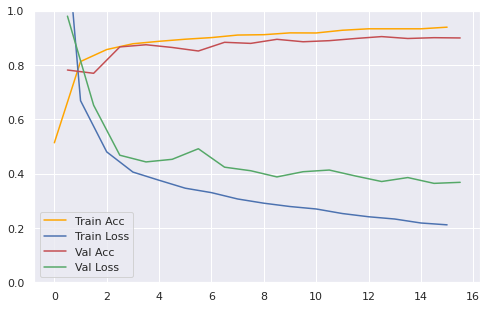

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 244us/sample - loss: 2.2848 - accuracy: 0.2283 - val_loss: 2.2670 - val_accuracy: 0.2900
Epoch 2/20
3000/3000 [==============================] - 0s 152us/sample - loss: 2.2202 - accuracy: 0.3883 - val_loss: 2.1625 - val_accuracy: 0.4230
Epoch 3/20
3000/3000 [==============================] - 0s 150us/sample - loss: 1.9149 - accuracy: 0.5293 - val_loss: 1.4787 - val_accuracy: 0.6260
Epoch 4/20
3000/3000 [==============================] - 0s 151us/sample - loss: 1.0143 - accuracy: 0.7157 - val_loss: 0.7442 - val_accuracy: 0.7780
Epoch 5/20
3000/3000 [==============================] - 0s 145us/sample - loss: 0.6146 - accuracy: 0.8120 - val_loss: 0.5709 - val_accuracy: 0.8370
Epoch 6/20
3000/3000 [==============================] - 0s 157us/sample - loss: 0.4772 - accuracy: 0.8557 - val_loss: 0.5083 - val_accuracy: 0.8400
Epoch 7/20
3000/3000 [==============================] - 0s 158us

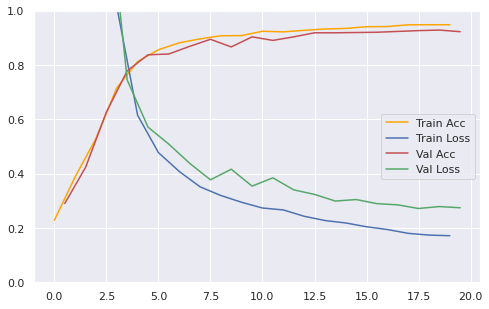

[[1, 0.894, 0.9065], [2, 0.904, 0.9132], [3, 0.928, 0.9255]]


In [28]:
# Number of layers
res=[]
for n in [1, 2, 3]:
    valacc, testacc, history, model = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[n,valacc,testacc]]
print(res)

Train on 30 samples, validate on 1000 samples
Epoch 1/20
30/30 [==============================] - 0s 9ms/sample - loss: 2.3040 - accuracy: 0.1333 - val_loss: 2.2939 - val_accuracy: 0.1460
Epoch 2/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.3010 - accuracy: 0.1667 - val_loss: 2.2932 - val_accuracy: 0.1400
Epoch 3/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2980 - accuracy: 0.1667 - val_loss: 2.2927 - val_accuracy: 0.1410
Epoch 4/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2953 - accuracy: 0.1667 - val_loss: 2.2921 - val_accuracy: 0.1380


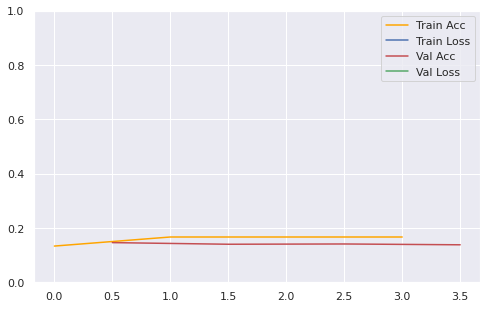

Train on 300 samples, validate on 1000 samples
Epoch 1/20
300/300 [==============================] - 0s 1ms/sample - loss: 2.2953 - accuracy: 0.1100 - val_loss: 2.2962 - val_accuracy: 0.1140
Epoch 2/20
300/300 [==============================] - 0s 328us/sample - loss: 2.2905 - accuracy: 0.1400 - val_loss: 2.2929 - val_accuracy: 0.1160
Epoch 3/20
300/300 [==============================] - 0s 339us/sample - loss: 2.2859 - accuracy: 0.1733 - val_loss: 2.2898 - val_accuracy: 0.1410
Epoch 4/20
300/300 [==============================] - 0s 332us/sample - loss: 2.2815 - accuracy: 0.2033 - val_loss: 2.2866 - val_accuracy: 0.1420
Epoch 5/20
300/300 [==============================] - 0s 337us/sample - loss: 2.2766 - accuracy: 0.2067 - val_loss: 2.2833 - val_accuracy: 0.1590
Epoch 6/20
300/300 [==============================] - 0s 329us/sample - loss: 2.2714 - accuracy: 0.1967 - val_loss: 2.2797 - val_accuracy: 0.1690
Epoch 7/20
300/300 [==============================] - 0s 346us/sample - loss: 2

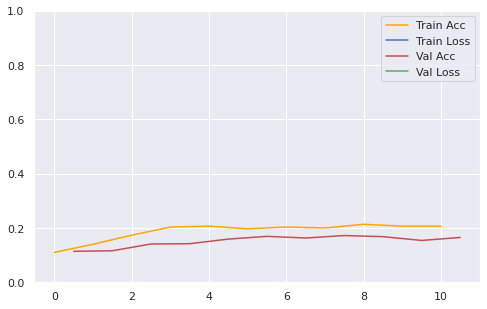

Train on 1500 samples, validate on 1000 samples
Epoch 1/20
1500/1500 [==============================] - 0s 309us/sample - loss: 2.2753 - accuracy: 0.1280 - val_loss: 2.2658 - val_accuracy: 0.1820
Epoch 2/20
1500/1500 [==============================] - 0s 170us/sample - loss: 2.2351 - accuracy: 0.2713 - val_loss: 2.2206 - val_accuracy: 0.3510
Epoch 3/20
1500/1500 [==============================] - 0s 163us/sample - loss: 2.1576 - accuracy: 0.3947 - val_loss: 2.1140 - val_accuracy: 0.4690
Epoch 4/20
1500/1500 [==============================] - 0s 166us/sample - loss: 1.9501 - accuracy: 0.5053 - val_loss: 1.7903 - val_accuracy: 0.5610
Epoch 5/20
1500/1500 [==============================] - 0s 167us/sample - loss: 1.4162 - accuracy: 0.6593 - val_loss: 1.1904 - val_accuracy: 0.6320
Epoch 6/20
1500/1500 [==============================] - 0s 168us/sample - loss: 0.9123 - accuracy: 0.7287 - val_loss: 0.8632 - val_accuracy: 0.7420
Epoch 7/20
1500/1500 [==============================] - 0s 168us

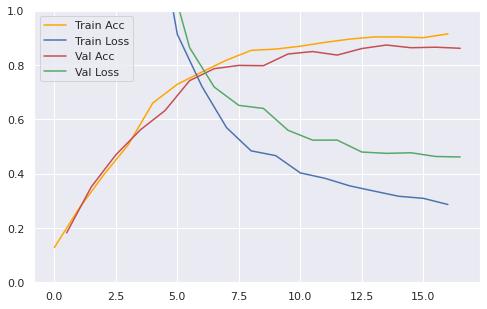

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 215us/sample - loss: 2.2671 - accuracy: 0.2167 - val_loss: 2.2099 - val_accuracy: 0.3850
Epoch 2/20
3000/3000 [==============================] - 0s 144us/sample - loss: 2.0463 - accuracy: 0.4737 - val_loss: 1.7218 - val_accuracy: 0.6270
Epoch 3/20
3000/3000 [==============================] - 0s 144us/sample - loss: 1.1487 - accuracy: 0.6997 - val_loss: 0.8044 - val_accuracy: 0.7350
Epoch 4/20
3000/3000 [==============================] - 0s 144us/sample - loss: 0.6266 - accuracy: 0.8007 - val_loss: 0.5730 - val_accuracy: 0.8250
Epoch 5/20
3000/3000 [==============================] - 0s 145us/sample - loss: 0.4846 - accuracy: 0.8480 - val_loss: 0.5135 - val_accuracy: 0.8430
Epoch 6/20
3000/3000 [==============================] - 0s 144us/sample - loss: 0.4057 - accuracy: 0.8723 - val_loss: 0.4746 - val_accuracy: 0.8580
Epoch 7/20
3000/3000 [==============================] - 0s 144us

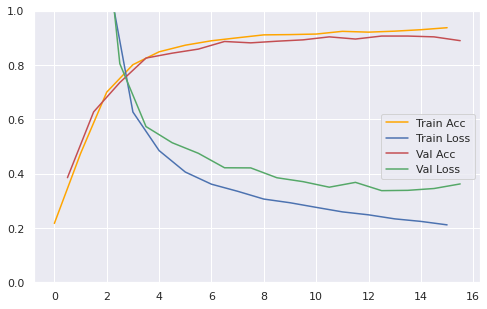

[[30, 0.146, 0.138], [300, 0.172, 0.1782], [1500, 0.873, 0.868], [3000, 0.906, 0.9139]]


In [29]:
# Training set size
res=[]
for ntr in [n_train*0.01, n_train*0.1, n_train*0.5, n_train]:
    valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, int(ntr), n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[int(ntr),valacc,testacc]]
print(res)

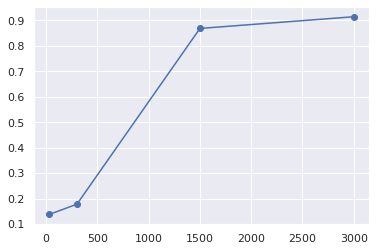

In [30]:
# Plot results (test accuracy vs factor that is changing)
res=np.array(res)
plt.plot(res[:,0],res[:,2],'-o')
plt.show()